
Time Series Analysis and Forecasting with CNNs

Convolutional Neural Network models, or CNNs for short, can be applied to time series forecasting. I will be presenting different type of scenarios that we usually come across during solving problems related with time series and the variety of CNN architectures that we can use to tackle them.

Variety of time series related problems:

1. CNN Models for Univariate time series

2. CNN Models for Multivariate time series

3. CNN Models for Multistep time series

4. CNN Models for Multivariate and Multisteps time series

Imports

In [5]:
import torch 
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.metrics import mean_squared_error


Data Description

The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years. The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute.

It is a multivariate series comprised of seven variables (besides the date and time); they are:

global active power: The total active power consumed by the household (kilowatts).

global reactive power: The total reactive power consumed by the household (kilowatts). ˆ voltage: Average voltage (volts).

global intensity: Average current intensity (amps).

sub metering 1: Active energy for kitchen (watt-hours of active energy).

sub metering 2: Active energy for laundry (watt-hours of active energy).

sub metering 3: Active energy for climate control systems (watt-hours of active energy).


Problem Framing
Given some number of prior days of total daily power consumption, predict the next standard week of daily power consumption?

Solution Approach

Since we have to do some kind of prediction for whole week or for each day for next 7 days, this framing of the problem is referred to as a multi-step time series forecasting problem, given the multiple forecast steps.

A model that makes use of multiple input variables may be referred to as a multivariate multi-step time series forecasting model.

This framing of the dataset also suggests that it would be useful to downsample the per-minute observations of power consumption to daily totals.

Train and Test Sets

We will use the first 3 years of data for training predictive models and the final year for evaluating models.

The data in a given dataset will be divided into standard weeks. These are weeks that begin on a Sunday and end on a Saturday. This is a realistic and useful way for using the chosen framing of the model, where the power consumption for the week ahead can be predicted.

It is also helpful with modeling, where models can be used to predict a specific day (e.g. Wednesday) or the entire sequence.

In [26]:
df = pd.read_csv('Data/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/ipykernel_5735/3140453207.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('Data/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/ipykernel_5735/3140453207.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('Data/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/i

In [27]:
df.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [28]:
df.shape

(2075259, 7)

In [29]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [30]:
#Missing value 
df.isna().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [31]:
df['Sub_metering_2'].unique()

array(['1.000', '2.000', '0.000', '16.000', '37.000', '36.000', '22.000',
       '12.000', '27.000', '20.000', '9.000', '4.000', '3.000', '5.000',
       '13.000', '35.000', '28.000', '26.000', '24.000', '21.000',
       '17.000', '33.000', '25.000', '23.000', '18.000', '30.000',
       '31.000', '7.000', '38.000', '29.000', '50.000', '71.000',
       '59.000', '62.000', '70.000', '40.000', '34.000', '8.000',
       '15.000', '6.000', '32.000', '19.000', '14.000', '49.000',
       '72.000', '73.000', '61.000', '39.000', '42.000', '10.000',
       '56.000', '11.000', '?', '43.000', '67.000', '63.000', '53.000',
       '65.000', '52.000', '69.000', '48.000', '74.000', '41.000',
       '47.000', '58.000', '68.000', '64.000', '75.000', '46.000',
       '57.000', '60.000', '66.000', '44.000', '78.000', '77.000',
       '76.000', '51.000', '55.000', '45.000', '54.000', '79.000',
       '80.000'], dtype=object)

In [33]:
# we have "?" in the columns so we need to replace it 

df.replace('?',None,inplace=True)

In [34]:
df['Sub_metering_3'].unique()

array([17., 16., 18.,  9.,  0.,  5., 19., 10., 20.,  8.,  4.,  2.,  3.,
       11., 13.,  6., 15., nan, 12.,  1., 14.,  7., 23., 25., 26., 28.,
       27., 21., 22., 29., 24., 30., 31.])

In [35]:
df['Sub_metering_2'].unique()

array(['1.000', '2.000', '0.000', '16.000', '37.000', '36.000', '22.000',
       '12.000', '27.000', '20.000', '9.000', '4.000', '3.000', '5.000',
       '13.000', '35.000', '28.000', '26.000', '24.000', '21.000',
       '17.000', '33.000', '25.000', '23.000', '18.000', '30.000',
       '31.000', '7.000', '38.000', '29.000', '50.000', '71.000',
       '59.000', '62.000', '70.000', '40.000', '34.000', '8.000',
       '15.000', '6.000', '32.000', '19.000', '14.000', '49.000',
       '72.000', '73.000', '61.000', '39.000', '42.000', '10.000',
       '56.000', '11.000', None, '43.000', '67.000', '63.000', '53.000',
       '65.000', '52.000', '69.000', '48.000', '74.000', '41.000',
       '47.000', '58.000', '68.000', '64.000', '75.000', '46.000',
       '57.000', '60.000', '66.000', '44.000', '78.000', '77.000',
       '76.000', '51.000', '55.000', '45.000', '54.000', '79.000',
       '80.000'], dtype=object)

In [36]:
df["Sub_metering_3"]=df[['Sub_metering_3']].fillna(method='ffill')

/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/ipykernel_5735/2024096273.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Sub_metering_3"]=df[['Sub_metering_3']].fillna(method='ffill')


In [38]:
df.dtypes

Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object


Most of the ML models expect data to be of float32 type

In [39]:
df=df.astype('float32')

In [40]:
df.dtypes

Global_active_power      float32
Global_reactive_power    float32
Voltage                  float32
Global_intensity         float32
Sub_metering_1           float32
Sub_metering_2           float32
Sub_metering_3           float32
dtype: object


Downsampling data to day level

In [41]:
#resamoling 

daily_df=df.resample("D")
dataset=daily_df.sum()

dataset.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0


In [62]:
dataset.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0
2006-12-21,1716.624023,144.166000,346616.31250,7238.600098,1765.0,2623.0,10421.0
2006-12-22,2341.337891,186.906006,347305.75000,9897.000000,3151.0,350.0,11131.0
2006-12-23,4773.386230,221.470001,345795.93750,20200.400391,2669.0,425.0,14726.0
2006-12-24,2550.011963,149.899994,348029.90625,11002.200195,1703.0,5082.0,6891.0


In [42]:
dataset.tail(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2010-11-24,1796.248047,132.460007,345644.59375,7559.399902,1096.0,2848.0,12224.0
2010-11-25,1431.163940,116.127998,347812.21875,6004.000000,1076.0,426.0,5072.0
2010-11-26,1488.104004,120.826004,303487.56250,6259.799805,1080.0,385.0,9989.0



Train and Test Split

The final year of the data is in 2010 and the first Sunday for 2010 was January 3rd. The data ends in mid November 2010 and the closest final Saturday in the data is November 20th. This gives 46 weeks of test data.

The function split dataset() below splits the daily data into train and test sets and organizes each into standard weeks. Specific row offsets are used to split the data using knowledge of the dataset.

The split datasets are then organized into weekly data using the NumPy split() function.

In [76]:
dataset.shape

(1442, 7)

In [43]:

from numpy import array, split


In [58]:

def split_dataset(data):
    #split into standard weeks
    train_sample, test_sample = data[1:-328], data[-328:-6]
    print(train_sample[0])
    print("----------")
    print(test_sample[0])
    train = torch.tensor(split(train_sample, len(train_sample)/7))
    test = torch.tensor(split(test_sample, len(test_sample)/7))

    return train, test

In [59]:
train, test=split_dataset(dataset.values)

[3.390460e+03 2.260060e+02 3.457253e+05 1.439860e+04 2.033000e+03
 4.187000e+03 1.334100e+04]
----------
[2.0834541e+03 1.9161000e+02 3.5099212e+05 8.7035996e+03 3.8420000e+03
 4.9200000e+03 1.0074000e+04]


/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/ipykernel_5735/664690823.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  train = torch.tensor(split(train_sample, len(train_sample)/7))


In [68]:
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

torch.Size([159, 7, 7])
tensor(3390.4600) tensor(1308.8361)
torch.Size([46, 7, 7])
tensor(2083.4541) tensor(2197.0061)


In [75]:
train.shape

torch.Size([159, 7, 7])

In [92]:
train[0]

tensor([[3.3905e+03, 2.2601e+02, 3.4573e+05, 1.4399e+04, 2.0330e+03, 4.1870e+03,
         1.3341e+04],
        [2.2038e+03, 1.6179e+02, 3.4737e+05, 9.2472e+03, 1.0630e+03, 2.6210e+03,
         1.4018e+04],
        [1.6662e+03, 1.5094e+02, 3.4848e+05, 7.0940e+03, 8.3900e+02, 7.6020e+03,
         6.1970e+03],
        [2.2257e+03, 1.6100e+02, 3.4892e+05, 9.3130e+03, 0.0000e+00, 2.6480e+03,
         1.4063e+04],
        [1.7166e+03, 1.4417e+02, 3.4662e+05, 7.2386e+03, 1.7650e+03, 2.6230e+03,
         1.0421e+04],
        [2.3413e+03, 1.8691e+02, 3.4731e+05, 9.8970e+03, 3.1510e+03, 3.5000e+02,
         1.1131e+04],
        [4.7734e+03, 2.2147e+02, 3.4580e+05, 2.0200e+04, 2.6690e+03, 4.2500e+02,
         1.4726e+04]])

In [107]:
def to_supervised(train,n_input,n_out=7):
    data=train.reshape(train.shape[0]*train.shape[1],train.shape[2])
    X,y=[],[]
    in_start=0

    for _ in range(len(data)):
        in_end=in_start+n_input
        out_end=in_end +n_out

        if out_end<len(data):
            x_input=data[in_start:in_end,0]
            x_input=x_input.view((len(x_input),1))
            X.append(x_input)
            y.append(data[in_end:out_end,0])
        in_start+=1

    return torch.stack(X),torch.stack(y)


In [108]:
X,y=to_supervised(train,7,7)

In [109]:
X.shape

torch.Size([1099, 7, 1])


When we run the above function on the entire training dataset, we transform 159 samples into 1,099; specifically, the transformed dataset has the shapes X=[1099, 7, 1] and y=[1099, 7].

In [110]:
train[0] 

tensor([[3.3905e+03, 2.2601e+02, 3.4573e+05, 1.4399e+04, 2.0330e+03, 4.1870e+03,
         1.3341e+04],
        [2.2038e+03, 1.6179e+02, 3.4737e+05, 9.2472e+03, 1.0630e+03, 2.6210e+03,
         1.4018e+04],
        [1.6662e+03, 1.5094e+02, 3.4848e+05, 7.0940e+03, 8.3900e+02, 7.6020e+03,
         6.1970e+03],
        [2.2257e+03, 1.6100e+02, 3.4892e+05, 9.3130e+03, 0.0000e+00, 2.6480e+03,
         1.4063e+04],
        [1.7166e+03, 1.4417e+02, 3.4662e+05, 7.2386e+03, 1.7650e+03, 2.6230e+03,
         1.0421e+04],
        [2.3413e+03, 1.8691e+02, 3.4731e+05, 9.8970e+03, 3.1510e+03, 3.5000e+02,
         1.1131e+04],
        [4.7734e+03, 2.2147e+02, 3.4580e+05, 2.0200e+04, 2.6690e+03, 4.2500e+02,
         1.4726e+04]])

Next, we can define and fit the CNN model on the training data. This multi-step time series forecasting problem is an autoregression

Model Architecture

convolution layer with 16 filters and kernel size = 3

Relu activation function

A pooling layer

Flattening

Linear layer with 10 nodes

Relu activation function

Linear layer with n_out nodes

MSE as loss function

Optimizer - Adam

In [125]:
#define Model

class UnivariateCNNModel(nn.Module):
    def __init__(self,n_timestamp,n_features):
        super().__init__()
        self.conv_net=nn.Sequential(
            nn.Conv1d(in_channels=n_features,out_channels=16,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.flt_layer=nn.Flatten()
        self.ln_layer=nn.Sequential(
            nn.Linear(in_features=32,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=n_timestamp)
        )
    def forward(self, X):
        #X -> (B, T, C)
        B, T, C = X.shape
        X = X.view(B, C, T)
        X = self.conv_net(X)
        # print(X.shape)
        X = self.flt_layer(X)
        X = self.ln_layer(X)

        return X
    

    

In [126]:
n_timestamp=7
n_features=1

model=UnivariateCNNModel(n_timestamp,n_features)

In [127]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = torch.nn.MSELoss()

In [128]:
n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]

print(f"n_timesteps : {n_timesteps}, n_features : {n_features}, n_outputs : {n_outputs}")

n_timesteps : 7, n_features : 1, n_outputs : 7


Training Loop

In [129]:
epochs=5

losses=[]

for _ in range(epochs):
    optimizer.zero_grad()
    y_pred=model(X)
    loss=criterion(y_pred,y)
    print(loss.item())
    losses.append(loss.item())
    loss.backward()
    optimizer.step()



2476169.75
2456234.75
2436106.25
2415704.0
2394994.0


Text(0, 0.5, 'Training Loss')

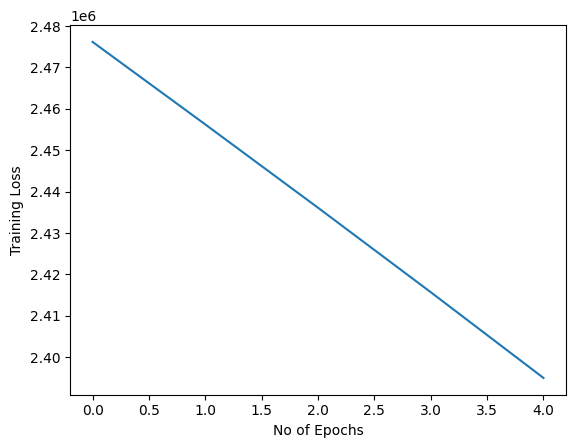

In [130]:
#plot the training losses

plt.plot(losses)
plt.xlabel("No of Epochs")
plt.ylabel("Training Loss")


Models will be evaluated using a scheme called walk-forward validation. This is where a model is required to make a one week prediction, then the actual data for that week is made available to the model so that it can be used as the basis for making a prediction on the subsequent week.

This is both realistic for how the model may be used in practice and beneficial to the models, allowing them to make use of the best available data.

For example:

Input -> predict

[Week1] -> Week2

[Week1 + Week2]  -> Week3

[Week1 + Week2 + Week3]  ->  Week4